<a href="https://colab.research.google.com/github/jihunyuk/Any/blob/main/23_02_21_Denoising_Bi_lstm_Autoencoder_jihunyuk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# load the required libraries
from random import shuffle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import easydict
from tqdm.notebook import trange, tqdm
from torch import optim
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
import torch.nn.functional as F

drive.mount('/content/gdrive')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# model parameters
timesteps = 60
sampling_frequency = 40
hidden_layer_units = 10
batch_size = 40000


Mounted at /content/gdrive


In [2]:
# -------------------------------------------- load data & pre-processing -------------------------------------------- #

# set this to the path of your data file
PPG_data_path = '/content/gdrive/MyDrive/20210828_KOHI_RNN_DAE-master/PPG_40Hz_10sec_25000set.txt'
PPG_data = np.loadtxt(PPG_data_path)
shuffle(PPG_data)

print(len(PPG_data))
print('The shape of the original dataset is %i by %i' % np.shape(PPG_data))  # (10000, 400) -> 10000 rows of 40Hz 10sec PPG data // (x, y) -> x : batch size
print('The shape of the %i timestep dataset is %i by %i' % (timesteps, int(np.ceil((400-timesteps)/timesteps)*len(PPG_data)), timesteps))

25000
The shape of the original dataset is 25000 by 400
The shape of the 60 timestep dataset is 150000 by 60


In [3]:
def signal_extraction(ppg_data):

    # create empty lists to hold training and validation datasets
    train_input_data_list = []
    train_output_data_list = []
    val_input_data_list = []
    val_output_data_list = []

    # loop through the original dataset and perform data extraction/noise addition on each row
    for datanum in range(len(ppg_data)):
        # separate the PPG segment in each row into timestep size
        for index in range(0, 400-timesteps, timesteps):

            # ---------- original data, normalized ----------
            a = ppg_data[datanum, index:index + timesteps].copy()
            a = a - np.min(a)
            a = a / np.max(a)

            # ---------- Gaussian noise data ----------
            noise1 = np.random.randn(len(a))/7
            b = a.copy() + noise1
            b = b - np.min(b)
            b = b / np.max(b)

            # ---------- Gaussian noise + low freq noise data ----------
            c = b.copy()
            slope = np.random.randn()
            for i in range(len(c)):
                c[i] = c[i] + slope/len(c)*i
            c = c - np.min(c)
            c = c / np.max(c)

            # ---------- Gaussian noise + low freq noise + saturation data ----------
            d = c.copy()
            location1 = np.random.randint(timesteps)
            location2 = location1 + np.random.randint(timesteps-location1)
            if np.random.rand() > 0:
              d[location1:location2] = np.ones(location2-location1, float)
            else: 
              d[location1:location2] = np.zeros(location2-location1, float)


            # put 80% of the data into the training dataset list, and 20% into the validation dataset list
            if datanum < 0.8 * len(ppg_data):
              if np.sum(np.isfinite(a))== len(a) and np.sum(np.isfinite(d))== len(d):
                train_input_data_list.append(d)  # CHANGE THIS TO THE NOISE-AUGMENTED DATA
                train_output_data_list.append(a)
            else:
              if np.sum(np.isfinite(a))== len(a) and np.sum(np.isfinite(d))== len(d):
                val_input_data_list.append(d)  # CHANGE THIS TO THE NOISE-AUGMENTED DATA
                val_output_data_list.append(a)


    # convert the dataset lists into arrays
    train_input_data_list = np.asarray(train_input_data_list, dtype=np.float32)
    train_output_data_list = np.asarray(train_output_data_list, dtype=np.float32)
    val_input_data_list = np.asarray(val_input_data_list, dtype=np.float32)
    val_output_data_list = np.asarray(val_output_data_list, dtype=np.float32)

    return train_input_data_list, train_output_data_list, val_input_data_list, val_output_data_list


[train_input_data_list, train_answer_data_list, val_input_data_list, val_answer_data_list] = signal_extraction(PPG_data)

<ipython-input-3-f260b27fcd9b>:17: RuntimeWarning: invalid value encountered in true_divide
  a = a / np.max(a)


In [4]:
train_input_data_list = np.reshape(train_input_data_list, [-1, 60, 1])
train_answer_data_list = np.reshape(train_answer_data_list, [-1, 60, 1])
val_input_data_list = np.reshape(val_input_data_list, [-1, 60, 1])
val_answer_data_list = np.reshape(val_answer_data_list, [-1, 60, 1])

print(np.shape(train_input_data_list))
print(np.shape(train_answer_data_list))
print('-------------------------------')
train_input = np.concatenate((train_input_data_list, train_answer_data_list), axis=2)
print(np.shape(train_input))
print('-------------------------------')
print('-------------------------------')

print(np.shape(val_input_data_list))
print(np.shape(val_answer_data_list))
print('-------------------------------')

val_input = np.concatenate((val_input_data_list, val_answer_data_list), axis=2)
print(np.shape(val_input))

(120000, 60, 1)
(120000, 60, 1)
-------------------------------
(120000, 60, 2)
-------------------------------
-------------------------------
(29999, 60, 1)
(29999, 60, 1)
-------------------------------
(29999, 60, 2)


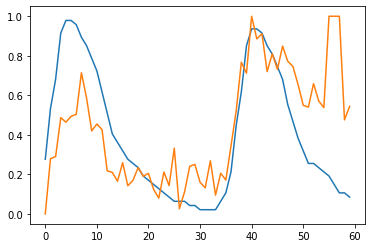

In [5]:
plt.figure()
plt.plot(PPG_data[0,0:60])
plt.plot(train_input_data_list[0,])
plt.show()

In [6]:
# if the deep learning model used here is recurrent, need to reshape the input data to match the keras LSTM input_shape
train_loader_AE = DataLoader(train_input, batch_size=batch_size, shuffle=True)
test_loader_AE = DataLoader(val_input, batch_size=batch_size, shuffle=True)

In [7]:
class Encoder(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.1,
                             bidirectional=True)
        

    def forward(self, x):
        # x: tensor of shape (batch_size, seq_length, hidden_size)
        outputs, (hidden, cell) = self.lstm(x)
        return (hidden, cell)

class Decoder(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.1,
                            bidirectional=True)        
        self.fc = nn.Linear(2*hidden_size, output_size)
   
        
    def forward(self, x, hidden):
        # x: tensor of shape (batch_size, seq_length, hidden_size)
        output, (hidden, cell) = self.lstm(x, hidden)
        prediction = self.fc(output)
        #prediction = output.view(40000, 60 ,1)
        return prediction, (hidden, cell)
       # return output, (hidden, cell)

In [8]:
## LSTM Auto Encoder
class LSTMAutoEncoder(nn.Module):

    def __init__(self,
                 input_dim: int,
                 latent_dim: int,
                 window_size: int=1,
                 **kwargs) -> None:

        super(LSTMAutoEncoder, self).__init__()
        # 1. hyper parameter
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.window_size = window_size

        if "num_layers" in kwargs:
            num_layers = kwargs.pop("num_layers")
        else:
            num_layers = 1
        # 2. encoder, decoder setting
        self.encoder = Encoder(
            input_size=input_dim,
            hidden_size=latent_dim,
            num_layers=num_layers,
        )
        self.reconstruct_decoder = Decoder(
            input_size=input_dim,
            output_size=input_dim,
            hidden_size=latent_dim,
            num_layers=num_layers,
        )
    # 3. feed-forward
    def forward(self, src:torch.Tensor, **kwargs):
        noisy = src[:,:,0]
        noisy = noisy.view([len(noisy),-1,1])
        label = src[:,:,1]
        label = label.view([len(label),-1,1])
        batch_size, sequence_length, var_length = label.size()

        ## Encoder 넣기
        encoder_hidden = self.encoder(noisy)
        
        inv_idx = torch.arange(sequence_length - 1, -1, -1).long()
        reconstruct_output = []
        temp_input = torch.zeros((batch_size, 1, var_length), dtype=torch.float).to(noisy.device)
        hidden = encoder_hidden
        for t in range(sequence_length):
            temp_input, hidden = self.reconstruct_decoder(temp_input, hidden)
            reconstruct_output.append(temp_input)
        reconstruct_output = torch.cat(reconstruct_output, dim=1)[:, inv_idx, :]
        
        return [reconstruct_output, label]

    # 4. calculate loss
    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        recons = args[0]
        input = args[1]

        ## MSE loss(Mean squared Error)
        loss =F.mse_loss(recons, input)
        return loss, recons, input

In [9]:
def run(args, model, train_loader, test_loader):
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

    ## iteration
    epochs = tqdm(range(args.max_iter//len(train_loader)+1))
    
    ## training
    count = 0
    best_loss = 100000000
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(enumerate(train_loader), total=len(train_loader), desc="training")

        for i, batch_data in train_iterator:
            
            if count > args.max_iter:
                return model
            count += 1
            
            batch_data = batch_data.to(args.device)
            predict_values = model(batch_data)
            loss, recons, input = model.loss_function(*predict_values)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_iterator.set_postfix({
                "train_loss": float(loss),
            })


        model.eval()
        eval_loss = 0
        test_iterator = tqdm(enumerate(test_loader), total=len(test_loader), desc="testing")
        with torch.no_grad():
            for i, batch_data in test_iterator:
                
                batch_data = batch_data.to(args.device)
                predict_values = model(batch_data)
                loss, recons, input = model.loss_function(*predict_values)

                eval_loss += loss.mean().item()

                test_iterator.set_postfix({
                    "eval_loss": float(loss),
                })
        eval_loss = eval_loss / len(test_loader)
        epochs.set_postfix({
             "Evaluation Score": float(eval_loss),
        })
        
        if(eval_loss < 0.024):
          recons=recons.cpu().detach()
          input=input.cpu().detach()
          plt.figure()
          plt.plot(recons[15000,:,:])
          plt.plot(input[15000,:,:])
          plt.show()

        if eval_loss < best_loss:
            best_loss = eval_loss
            # best evaluation 시점의 체크포인트 드라이브에 저장장
            torch.save(model, '/content/gdrive/MyDrive/checkpoint/checkpoint_best.pt')
        else:
            if args.early_stop:
                print('early stop condition   best_loss[{}]  eval_loss[{}]'.format(best_loss, eval_loss))
                return model
        
    return model

In [10]:
args = easydict.EasyDict({
    "batch_size": 40000, ## batch_size
    "device": torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'), ## GPU utility
    "input_size": 1, ## input dimension
    "latent_size": 10, ## Hidden layer dimension
    "output_size": 1, ## output dimention
    "window_size" : 60, ## sequence Length
    "num_layers": 1,     ## number of LSTM layer
    "learning_rate" : 0.01, ## learning rate
    "max_iter" : 100000, ## Iteration
    'early_stop' : False,  ## early stop
})

In [11]:
model = LSTMAutoEncoder(input_dim=args.input_size, latent_dim=args.latent_size, window_size=args.window_size, num_layers=args.num_layers)
model.to(args.device)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTMAutoEncoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 10, batch_first=True, dropout=0.1, bidirectional=True)
  )
  (reconstruct_decoder): Decoder(
    (lstm): LSTM(1, 10, batch_first=True, dropout=0.1, bidirectional=True)
    (fc): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [12]:
# best evaluation 시점의 체크포인트 모델 불러오기기
model = torch.load('/content/gdrive/MyDrive/checkpoint/checkpoint_best.pt')

  0%|          | 0/33334 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

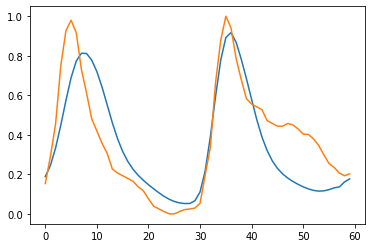

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

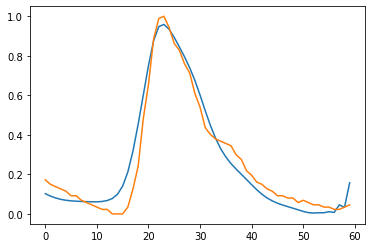

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

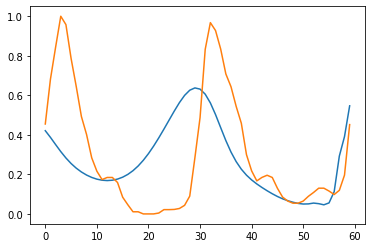

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

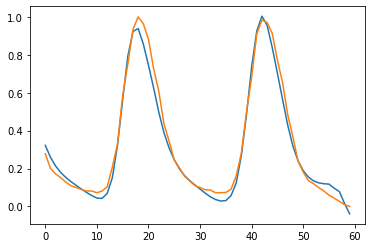

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

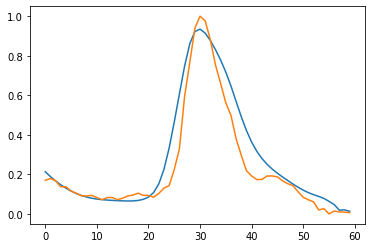

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

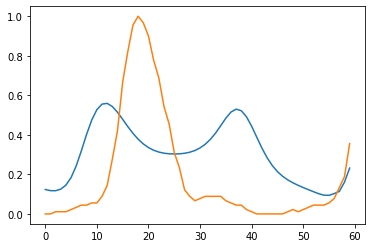

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

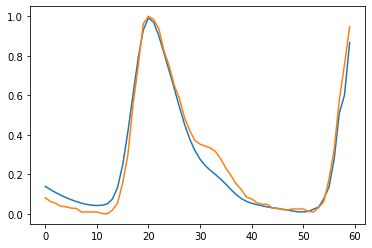

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

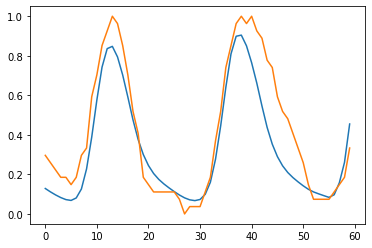

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

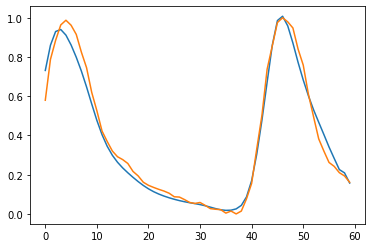

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

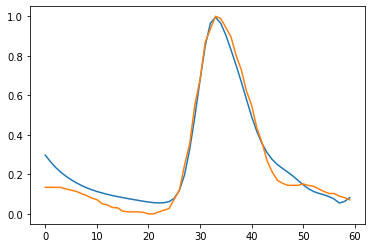

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

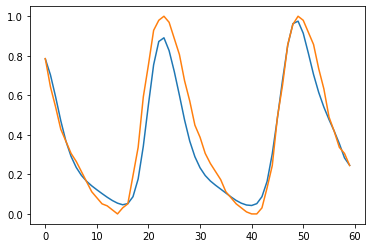

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

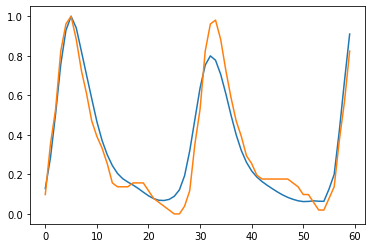

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

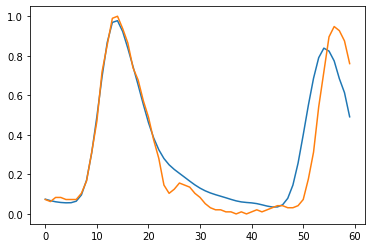

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

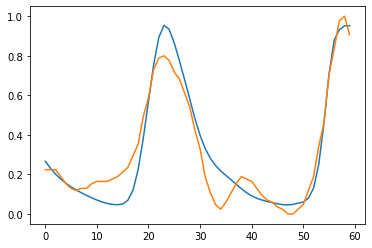

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

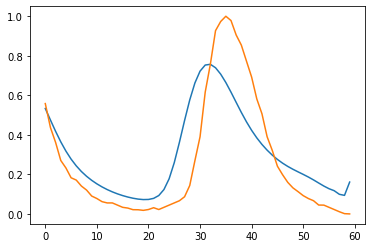

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

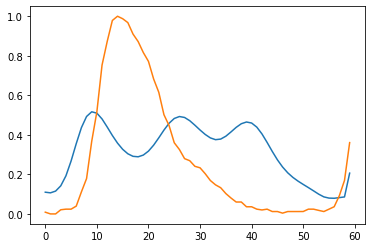

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

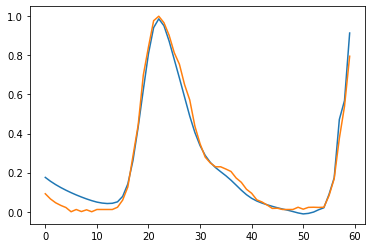

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

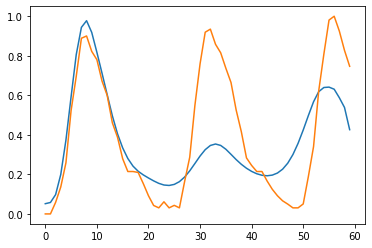

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

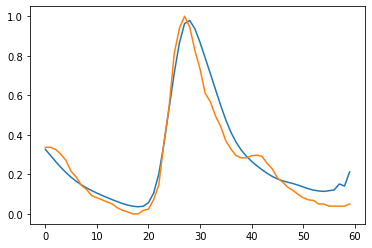

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

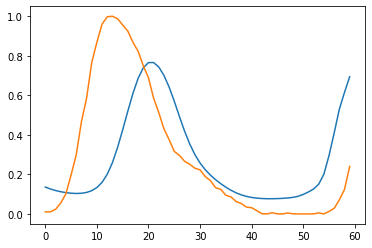

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

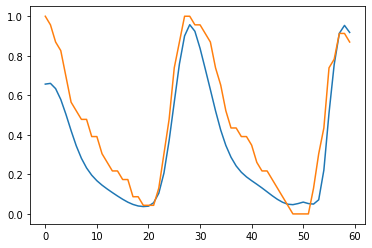

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

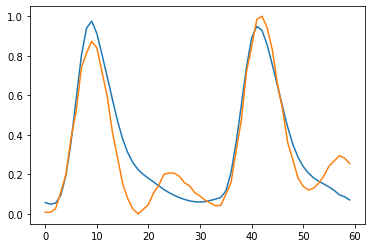

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

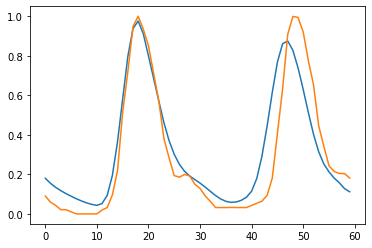

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

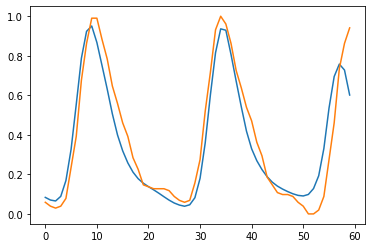

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

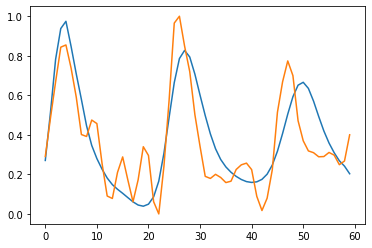

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

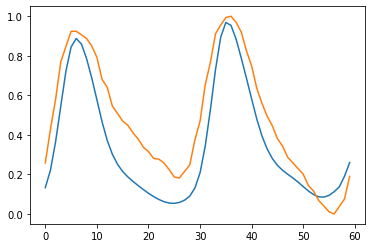

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

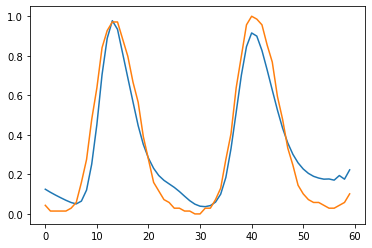

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

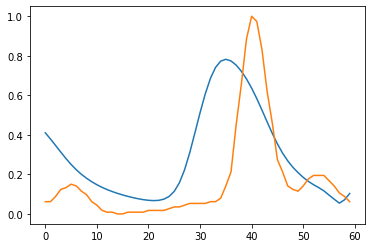

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

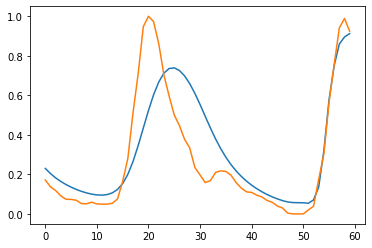

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

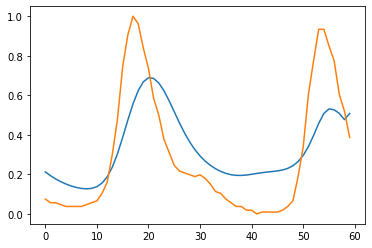

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

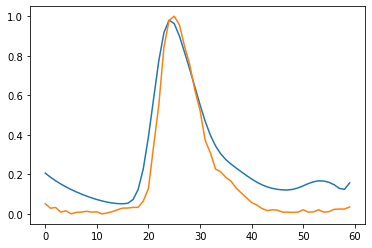

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

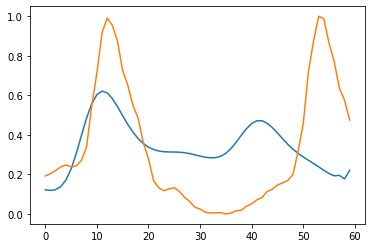

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

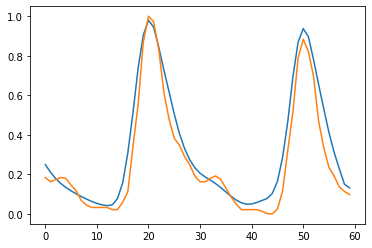

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

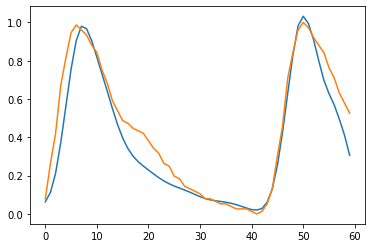

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

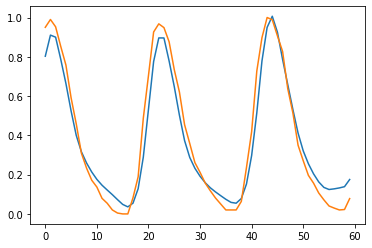

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

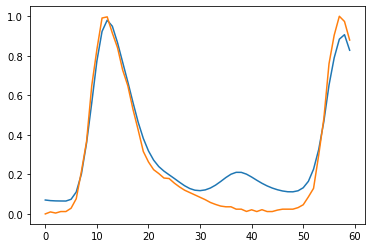

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

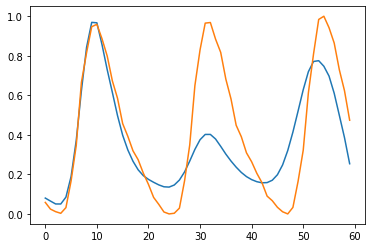

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

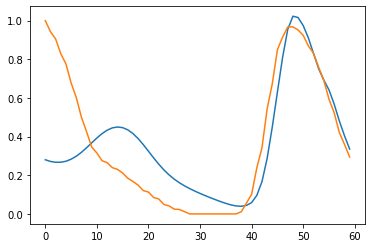

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

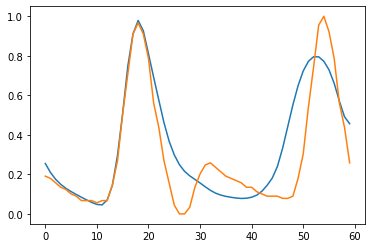

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

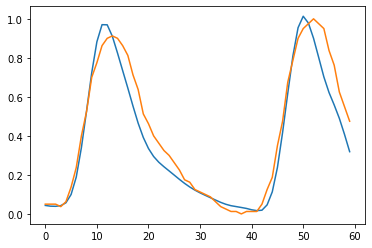

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

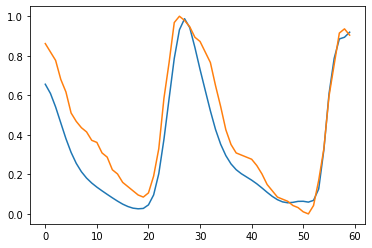

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

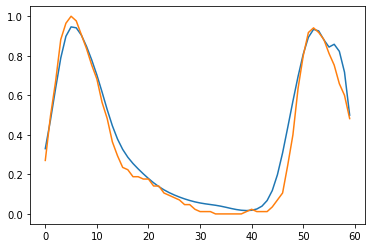

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

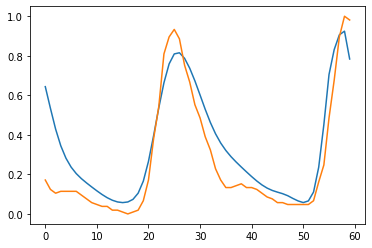

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

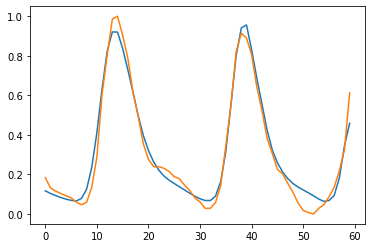

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

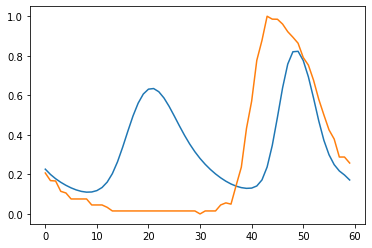

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

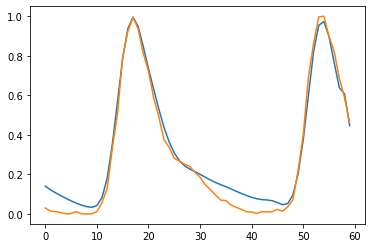

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

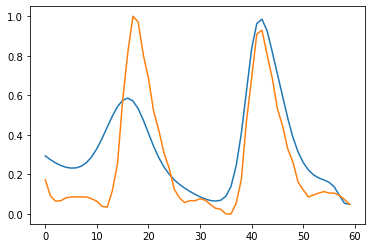

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

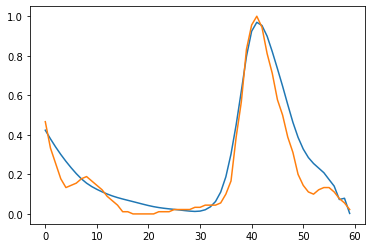

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

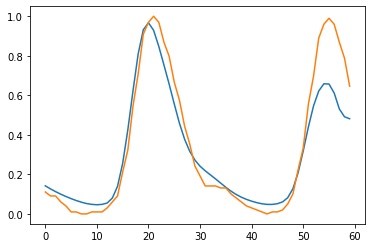

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

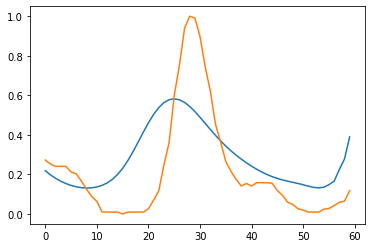

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

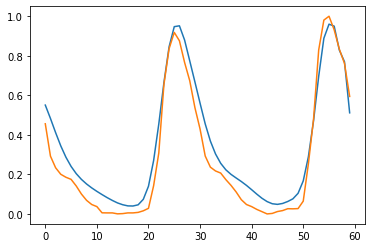

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

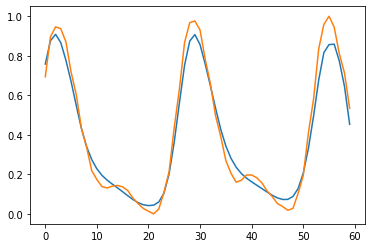

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

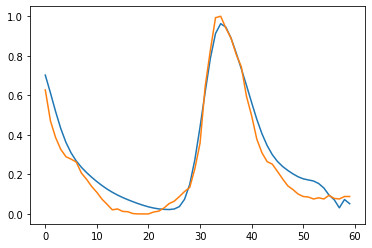

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

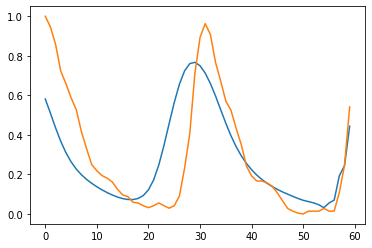

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

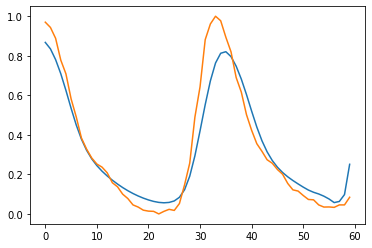

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

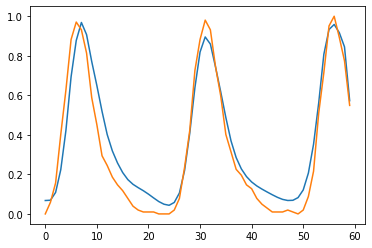

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

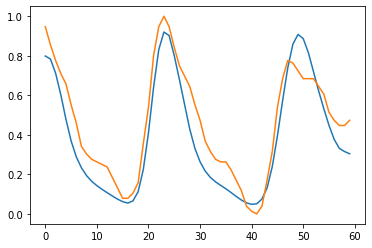

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

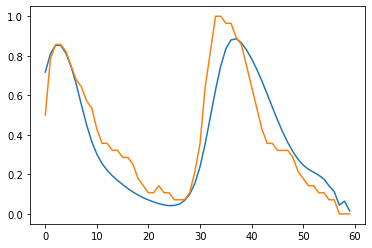

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

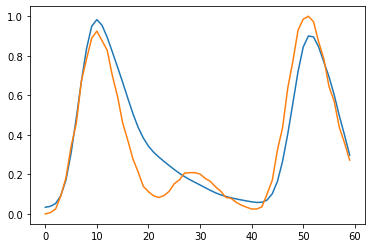

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

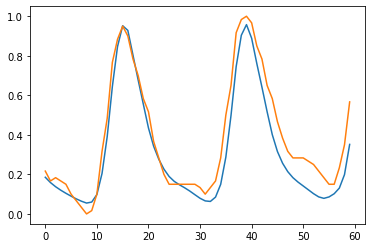

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

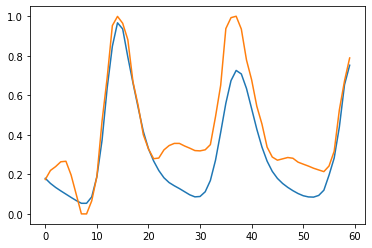

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

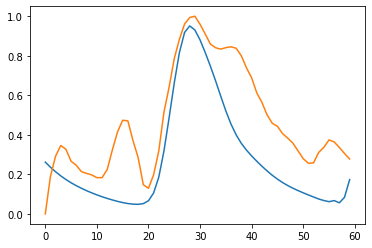

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

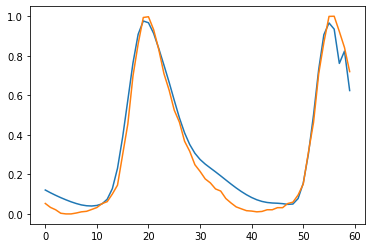

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

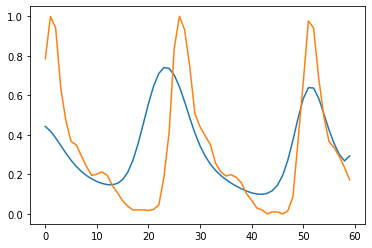

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

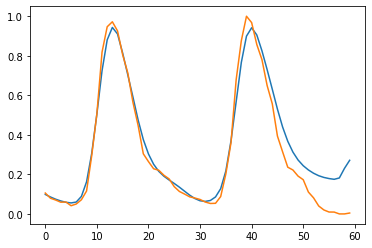

training:   0%|          | 0/3 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x7f3b2d1fe4c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tqdm/std.py", line 1161, in __del__
    def __del__(self):
KeyboardInterrupt: 


testing:   0%|          | 0/1 [00:00<?, ?it/s]

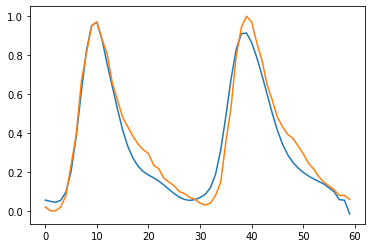

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

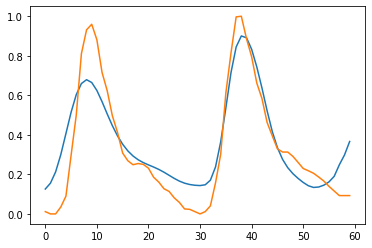

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

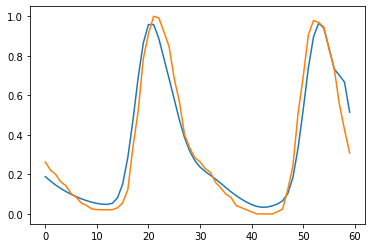

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

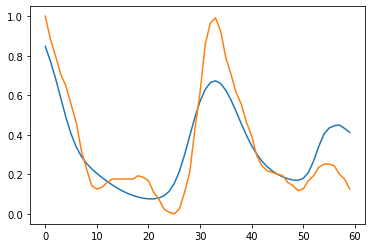

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

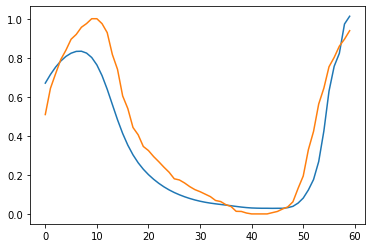

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

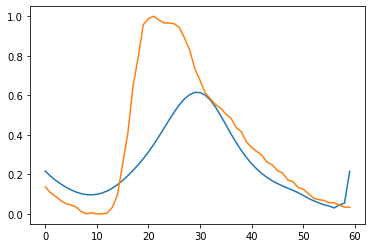

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

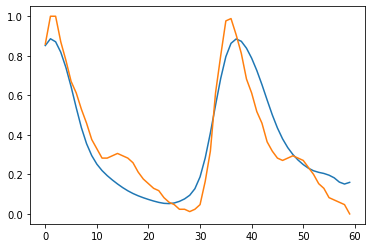

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

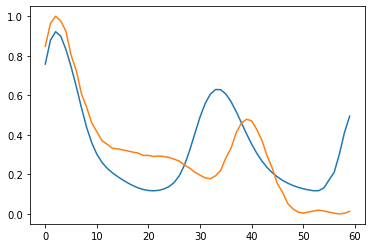

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

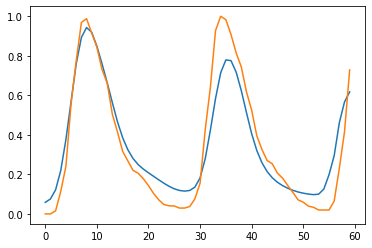

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

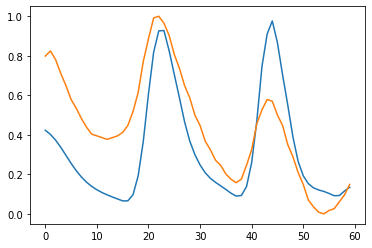

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

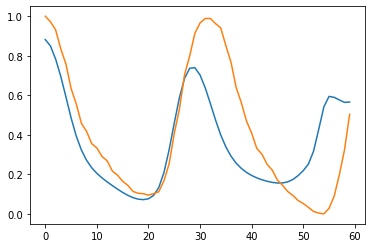

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

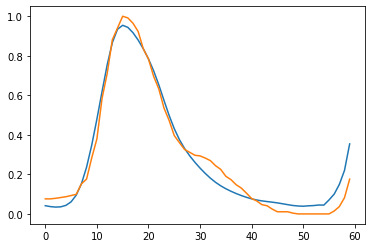

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

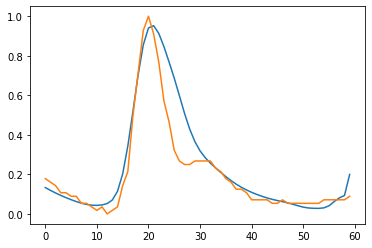

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

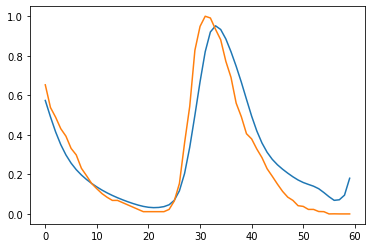

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

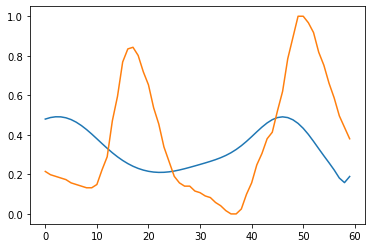

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

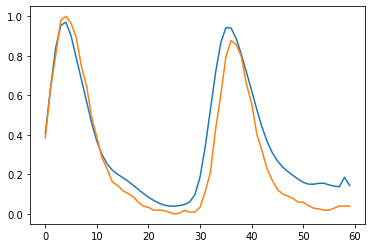

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

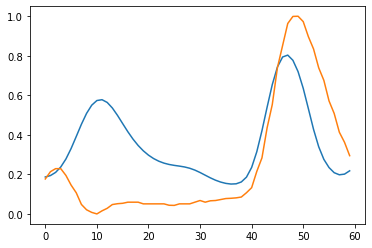

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

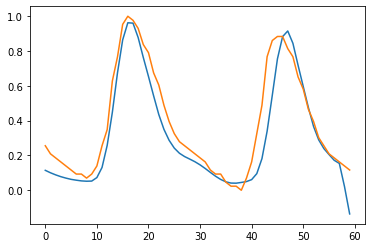

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

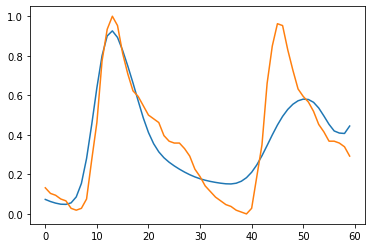

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

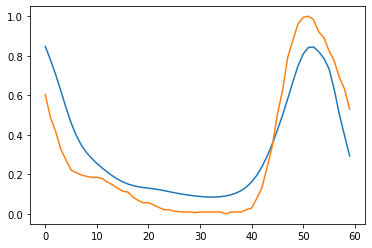

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

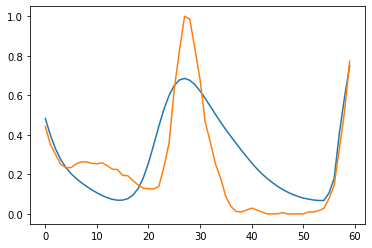

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

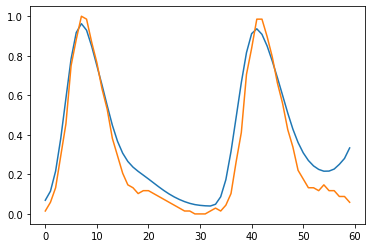

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

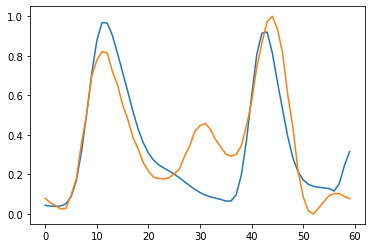

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

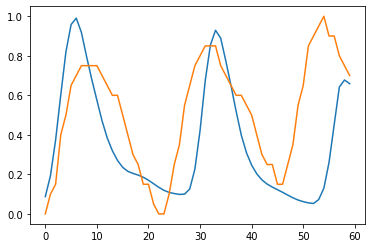

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

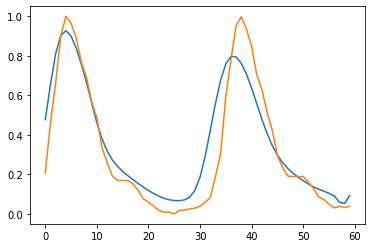

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

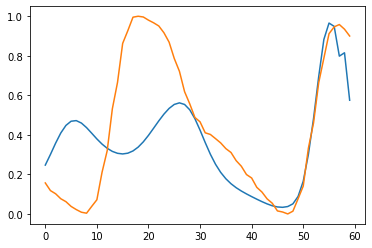

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

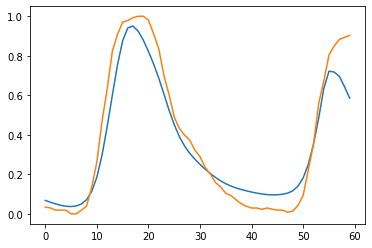

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

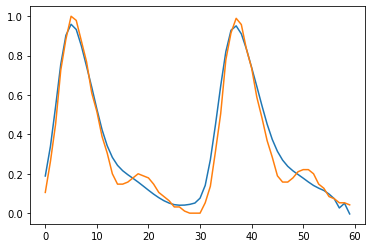

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

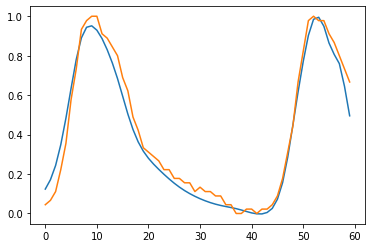

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

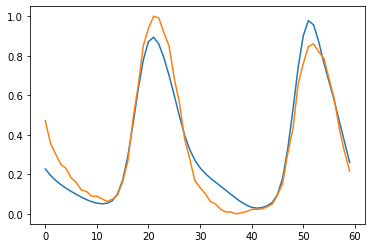

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

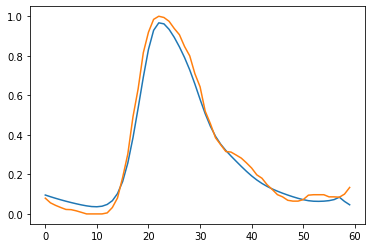

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

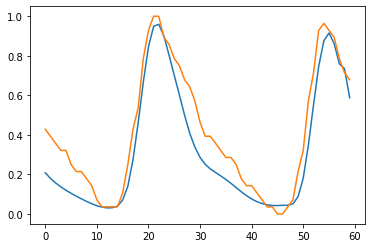

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

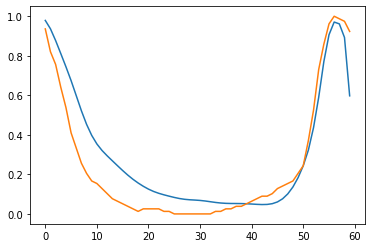

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

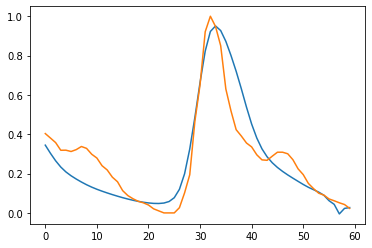

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

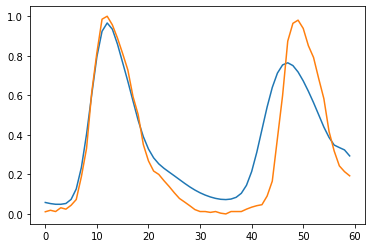

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

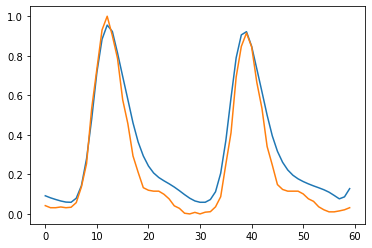

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

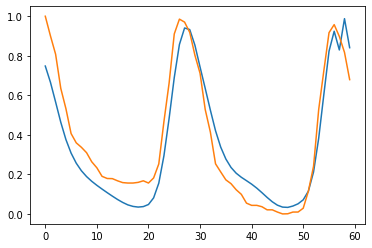

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

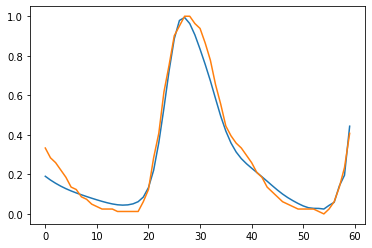

training:   0%|          | 0/3 [00:00<?, ?it/s]

testing:   0%|          | 0/1 [00:00<?, ?it/s]

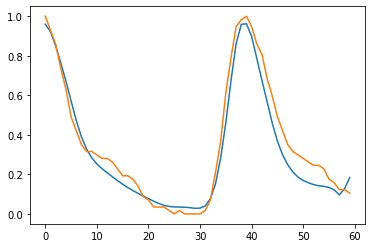

training:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
model = run(args, model, train_loader_AE, test_loader_AE)